In [ ]:

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()

        # Initial convolution layer with 3 input channels, 64 output channels, 3x3 kernel size, stride 1, padding 1, and no bias
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Batch normalization layer with 64 output channels
        self.bn1 = nn.BatchNorm2d(64)
        # ReLU activation function
        self.relu = nn.ReLU(inplace=True)

        # Residual blocks
        # First residual block with 64 input channels, 128 output channels, stride 2, and 2 blocks
        self.layer1 = self._make_layer(64, 128, 2, stride=2)
        # Second residual block with 128 input and output channels, stride 1, and 2 blocks
        self.layer2 = self._make_layer(128, 128, 2, stride=1)
        # Third residual block with 128 input channels, 256 output channels, stride 2, and 2 blocks
        self.layer3= self._make_layer(128, 256, 2, stride=2)

        # Average pooling layer with output size of 1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer with 256 input features and num_classes output features
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        # List to store the layers in the residual block
        layers = []
        # First layer in the residual block is a ResidualBlock module with in_channels input channels, out_channels output channels, and stride stride
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        # Add num_blocks - 1 more ResidualBlock modules with out_channels input and output channels, and stride 1
        for i in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        # Return a sequential module with all the layers in the residual block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution layer, followed by batch normalization and ReLU activation
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Residual blocks
        # Apply each residual block in turn
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # Average pooling and fully-connected layer
        # Apply the adaptive average pooling layer to get a 1x1 output
        x = self.avgpool(x)
        # Flatten the output
        x = x.view(x.size(0), -1)
        # Apply the fully connected layer to get the output scores
        x = self.fc(x)

        return x


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ResidualBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        # Stride value
        self.stride = stride

        # Skip connection
        if stride != 1 or in_channels != out_channels:
            # If the number of channels or stride changes, use a convolutional layer for the skip connection
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        else:
            # If the number of channels and stride remain the same, use an identity function for the skip connection
            self.skip = nn.Identity()

    def forward(self, x):
        # Save the original input tensor for the skip connection
        identity = self.skip(x)

        # First residual block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Second residual block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        # Third residual block
        x = self.conv3(x)
        x = self.bn3(x)
        
        # Add the original input tensor to the output of the final residual block
        x += identity
        x = self.relu(x)

        # Return the output tensor
        return x


In this code, PyTorch's transforms module is used to define two different sets of image transformations: one for the training set and another for the test set.

The transform_train transform includes the following steps:

RandomCrop: randomly crops a 32x32 pixel region from the input image and pads the edges with 4 pixels. This is a form of data augmentation that helps prevent overfitting by creating variations of the same image.
RandomHorizontalFlip: randomly flips the image horizontally with a 50% probability. This is another form of data augmentation that helps prevent overfitting by creating mirror images of the same object.
ToTensor: converts the image from a NumPy array to a PyTorch tensor, which is the preferred data type for PyTorch models.
Normalize: normalizes the tensor by subtracting the mean and dividing by the standard deviation. This step helps improve the convergence of the training algorithm by keeping the values in a reasonable range. The mean and standard deviation values used here are based on the statistics of the CIFAR-10 dataset, which is the dataset that this code is designed to work with.

In [ ]:


# Define transform for the training set
transform_train = transforms.Compose([
    # Apply a random crop to the image, padding the edges by 4 pixels
    transforms.RandomCrop(32, padding=4),
    # Apply a random horizontal flip to the image
    transforms.RandomHorizontalFlip(),
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # Normalize the tensor by subtracting the mean and dividing by the standard deviation
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

# Define transform for the test set
transform_test = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # Normalize the tensor by subtracting the mean and dividing by the standard deviation
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


In this code, the CIFAR-10 dataset is loaded into PyTorch tensors using the torchvision.datasets.CIFAR10 class. The dataset is split into three parts: a training set, a validation set, and a test set. Each set is loaded using a DataLoader object, which allows us to iterate over the dataset in batches during training.

The trainset variable is initialized with the specified transform_train transform, which applies data augmentation to the images in the training set. The trainloader object is then created with a batch size of 128, and the shuffle parameter set to True, which shuffles the images at the beginning of each epoch to prevent the model from overfitting.

The valset and testset variables are initialized with the transform_test transform, which normalizes the images without applying any data augmentation. The valloader and testloader objects are created with the same batch size and number of workers as trainloader, but with shuffle set to False, since we do not need to shuffle the images during validation or testing.

In [ ]:
# Load the CIFAR-10 dataset

# Load the training set with the specified transforms, batch size, and number of workers for parallel data loading
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Load the validation set with the specified transforms, batch size, and number of workers for parallel data loading
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)

# Load the test set with the specified transforms, batch size, and number of workers for parallel data loading
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:04<00:00, 37915306.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define the ResNet model

# Set the device to use for training and inference. If a CUDA-enabled GPU is available, use it, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set the learning rate to use for optimization
lr = 0.001


cuda


This code block trains a neural network model using the CIFAR-10 dataset with the ResNet architecture and Adam optimizer. The model is trained with early stopping based on the validation accuracy.

The ResNet model is created and moved to the device (e.g., CPU or GPU) where the training will occur. The optimizer is defined as Adam with the specified learning rate. The loss function is set as CrossEntropyLoss.

The training loop runs for a maximum of 300 epochs. For each epoch, the training data is loaded in batches using a DataLoader, and the model parameters are updated using backpropagation. The loss and accuracy are calculated for the training set for each epoch.

The validation accuracy is calculated for each epoch using the validation set. If the validation accuracy improves from the previous epoch, the model state is saved as the best model state. If there is no improvement in the validation accuracy for a number of epochs (determined by the patience parameter), training is stopped early.

After training, the saved best model state is loaded, and the accuracy is calculated using the test set. The number of parameters in the model is also printed.

Overall, this code block demonstrates the process of training a neural network model on a dataset with early stopping and calculating accuracy metrics.

In [ ]:
# Initialize lists to store accuracy and loss values
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

# Train the model using Adam optimizer with early stopping
net = ResNet().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# Define loss function
criterion = nn.CrossEntropyLoss()
print("\nTraining model with Adam optimizer...\n")
best_accuracy = 0.000
best_state_dict = None
patience = 30 # number of epochs to wait before stopping if val_accuracy doesn't improve
counter = 0 # counter for number of epochs without improvement in val_accuracy
for epoch in range(300):
    running_loss = 0.0
    train_correct = 0
    train_total = 0
  
    net.train() # set the model to training mode
    for i, data in enumerate(trainloader, 0): # iterate over the training data
        inputs, labels = data[0].to(device), data[1].to(device) # move the input data and the labels to the device

        optimizer.zero_grad() # zero out the gradients of the optimizer

        outputs = net(inputs) # compute the model outputs
        loss = criterion(outputs, labels) # compute the loss between the outputs and the labels
        loss.backward() # compute the gradients of the loss
        optimizer.step() # update the model weights using the optimizer

        running_loss += loss.item() # accumulate the loss
        _, predicted = torch.max(outputs.data, 1) # get the predicted labels from the model outputs
        train_total += labels.size(0) # increment the total number of samples during training
        train_correct += (predicted == labels).sum().item() # increment the number of correct predictions during training

    epoch_train_loss = running_loss / len(trainloader) # compute the average loss during training
    epoch_train_accuracy = 100 * train_correct / train_total # compute the accuracy during training

    # Calculate validation accuracy
     
    net.eval() # set the model to evaluation mode
    val_correct = 0 # initialize the number of correct predictions during validation to 0
    val_total = 0 # initialize the total number of samples during validation to 0
    with torch.no_grad(): # disable gradient computation during validation
        for data in valloader: # iterate over the validation data
          images, labels = data[0].to(device), data[1].to(device) # move the input data and the labels to the device
          outputs = net(images) # compute the model outputs
          _, predicted = torch.max(outputs.data, 1) # get the predicted labels from the model outputs
          val_total += labels.size(0) # increment the total number of samples during validation
          val_correct += (predicted == labels).sum().item() # increment the number of correct predictions during validation
      val_accuracy = 100 * val_correct / val_total # compute the accuracy during validation 
      val_loss = criterion(outputs, labels)

    # Save the accuracy and loss values for plotting
    train_acc_list.append(epoch_train_accuracy) # append the training accuracy of current epoch to the list
    val_acc_list.append(val_accuracy) # append the validation accuracy of current epoch to the list
    train_loss_list.append(epoch_train_loss) # append the training loss of current epoch to the list
    val_loss_list.append(val_loss) # append the validation loss of current epoch to the list

    # Save the model state with the best validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_state_dict = net.state_dict()
        counter = 0 # reset counter since there was improvement in val_accuracy
    else:
        counter += 1 # increment counter since there was no improvement in val_accuracy

    print('Epoch %d: train_loss=%.3f, train_accuracy=%.3f, val_accuracy=%.3f, val_loss=%.3f' % (epoch + 1, epoch_train_loss, epoch_train_accuracy, val_accuracy,val_loss))

    # Check if early stopping criteria has been met
    if counter >= patience:
        print("No improvement in validation accuracy for %d epochs. Stopping early." % patience)
        break


# Evaluate the test accuracy using the saved model state
# Load the saved model state with the best validation accuracy
net.load_state_dict(best_state_dict)

# Initialize variables for test accuracy calculation
test_correct = 0
test_total = 0



# Disable gradient calculation for faster computation and reduced memory usage
with torch.no_grad():
    # Loop through the test data
    for data in testloader:
        # Get the images and labels from the test data
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass the images through the network to get the outputs
        outputs = net(images)
        # Get the predicted labels by taking the index of the maximum value in each output tensor
        _, predicted = torch.max(outputs.data, 1)
        # Calculate the number of correct predictions and the total number of predictions
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate the test accuracy as the percentage of correct predictions
test_accuracy = 100 * test_correct / test_total

# Print the test accuracy
print('Test accuracy: %.3f' % test_accuracy)

# Count the number of trainable parameters in the network
num_params = sum(p.numel() for p in net.parameters())
print("\nNumber of parameters: ", num_params)





Training model with Adam optimizer...

Epoch 1: train_loss=1.510, train_accuracy=43.644, val_accuracy=50.780, val_loss=1.247
Epoch 2: train_loss=1.048, train_accuracy=62.342, val_accuracy=65.790, val_loss=0.898
Epoch 3: train_loss=0.849, train_accuracy=69.938, val_accuracy=68.620, val_loss=0.942
Epoch 4: train_loss=0.721, train_accuracy=74.784, val_accuracy=74.740, val_loss=0.657
Epoch 5: train_loss=0.616, train_accuracy=78.608, val_accuracy=76.570, val_loss=0.861
Epoch 6: train_loss=0.547, train_accuracy=81.026, val_accuracy=77.360, val_loss=0.978
Epoch 7: train_loss=0.501, train_accuracy=82.668, val_accuracy=81.240, val_loss=0.545
Epoch 8: train_loss=0.455, train_accuracy=84.246, val_accuracy=81.690, val_loss=0.530
Epoch 9: train_loss=0.418, train_accuracy=85.544, val_accuracy=83.870, val_loss=0.504
Epoch 10: train_loss=0.384, train_accuracy=86.772, val_accuracy=84.660, val_loss=0.408
Epoch 11: train_loss=0.356, train_accuracy=87.876, val_accuracy=84.200, val_loss=0.477
Epoch 12: tr

In [ ]:
from torchsummary import summary
net = ResNet().to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]           8,192
            Conv2d-5          [-1, 128, 16, 16]          73,728
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
    ResidualBlock-14          [-1, 128,

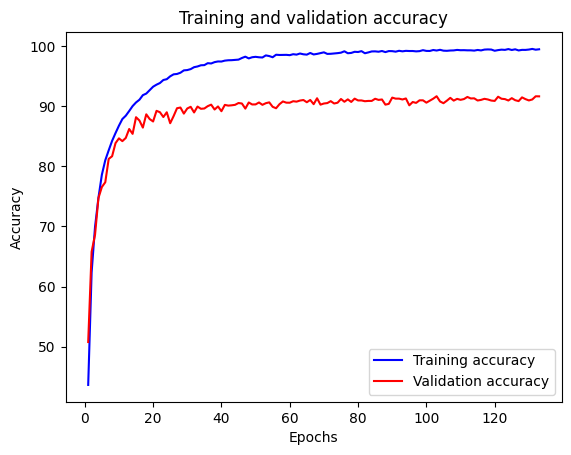

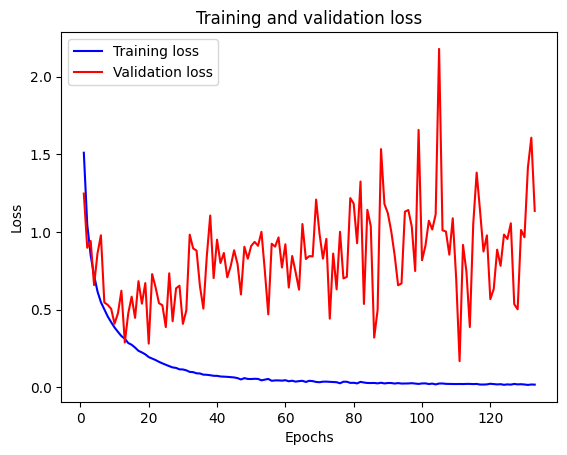

In [ ]:


# Plot the accuracy and loss values per epoch
epochs = range(1, len(train_acc_list) + 1)

plt.plot(epochs, train_acc_list, 'b', label='Training accuracy')
plt.plot(epochs, val_acc_list, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

val_loss_list_cpu = []
for val_loss in val_loss_list:
    val_loss_cpu = val_loss.cpu()
    val_loss_list_cpu.append(val_loss_cpu)

plt.plot(epochs, train_loss_list, 'b', label='Training loss')
plt.plot(epochs, val_loss_list_cpu, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()





